# Lecture 8: MCMC Convergence
AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University


In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

import pymc as pm
import time

/home/kevin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Bioassay experiment

This code follows an example from Gelman's "Bayesian Data Analysis".

We demonstrate this with an example and examine the convergence of the resulting samples. 

Bioassay (commonly used shorthand for biological assay), or biological standardisation is a type of scientific experiment. Bioassays are typically conducted to measure the effects of a substance on a living organism and are essential in the development of new drugs and in monitoring environmental pollutants. Both are procedures by which the potency (pharmacology) or the nature of a substance is estimated by studying its effects on living matter.

In this experiment 5 animals were tested for various doses and the number of deaths were recorded. The  death rate is usually modeled as logit$^{-1}$ with two parameters (see below). The goal is to estimate those parameters and be able to infer death rates as a function of dose. 

In [2]:
n=5
X=np.array([-0.86,-0.30,-0.05,0.73])
Y=np.array([0,1,3,5])

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$



In [3]:
## invLogit this is the same as a sigmoid
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

## posterior
def calc_posterior(a, b, y=Y, x=X):
    # Calculate joint posterior, given values for a, b 
    # x: dosage
    # y: number of deaths
    # a + b: parameters of the model
    p = np.product((logitInv(a+b*x)**y)*(1.0-logitInv( a+b*x))**(n-y))
    
    return p

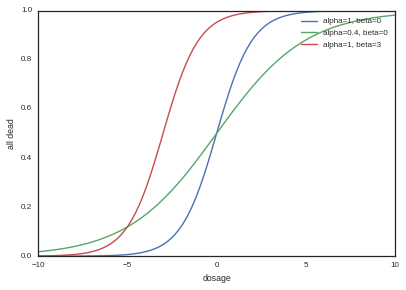

In [4]:
# some intuition about this model
xx = np.linspace(-10,10,100)
plt.plot(xx, logitInv(xx), label="alpha=1, beta=0")
plt.plot(xx, logitInv(0.4*xx), label="alpha=0.4, beta=0")
plt.plot(xx, logitInv(xx+3), label="alpha=1, beta=3")
plt.xlabel("dosage")
plt.ylabel("all dead")
plt.legend()


In [5]:
# check my posterior. I do a brute force just to make sure I do the right thing
X1 = np.linspace(-3,7,101) # alpha
X2 = np.linspace(-10, 30,100) # beta
k=0;j=0
pp=np.zeros((101,100))
for x1 in X1:
    j=0
    for x2 in X2:
        pp[k,j]=calc_posterior(x1,x2)
        j +=1
    k +=1
    


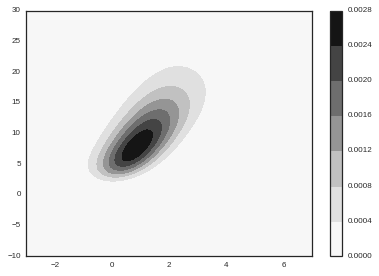

In [6]:
# look at the posterior distribution
plt.contourf(X1,X2,pp.T)
plt.colorbar()

In [7]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_std=[1,1], doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print 'Iterations left: ', n_iterations-i
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob/current_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted

Create the sample for the posterior using MH

Let's look at the acceptance ratio to tune the stepsize
Note that this most probably should be better done after the burn in, but I don't want the simulations to run for too long during the lecture

[ 0.31796  0.36768]


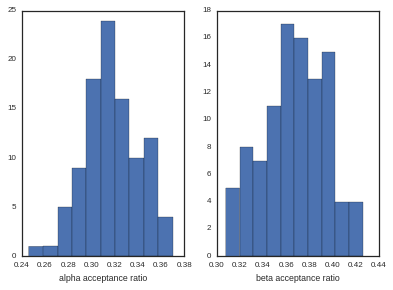

In [8]:
n_iter = 500
acc_ratios = []
for i in range(100):
    start_alpha = np.random.rand(1)*10 - 3
    start_beta = np.random.rand(1)*40 - 10
    trace, acc = metropolis(n_iter, (start_alpha, start_beta), [3.0,12.0], doPrint=False) #3.0, 12.0
    acc_ratios.append(acc/np.double(n_iter))

acc_ratios = np.array(acc_ratios)
plt.subplot(1,2,1)
plt.hist(acc_ratios[:,0])
plt.xlabel("alpha acceptance ratio")
plt.subplot(1,2,2)
plt.hist(acc_ratios[:,1])
plt.xlabel("beta acceptance ratio")

print np.mean(acc_ratios, axis=0)

In [9]:
n_iter = 100000
trace, acc = metropolis(n_iter, (11,40), [3.0,12.0]) #(11,17) [3.0,12.0])
print acc/np.double(n_iter)

Iterations left:  100000
Iterations left:  90000
Iterations left:  80000
Iterations left:  70000
Iterations left:  60000
Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000
[ 0.31556  0.36166]


In [10]:
burnin = 10000    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

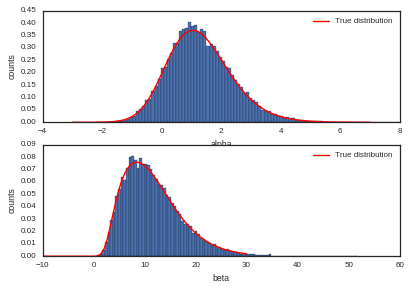

In [11]:
# histogram of alpha
plt.subplot(2,1,1) 
fig=plt.hist(alpha, bins=100, normed=True)
xx= np.linspace(-3,7,101)
pp_a = np.sum(pp, axis=1)
plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("alpha")
plt.ylabel("counts")

# histogram of beta
plt.subplot(2,1,2) 
fig=plt.hist(beta, bins=100, normed=True)
xx = np.linspace(-10, 30,100)
pp_b = np.sum(pp, axis=0)
plt.plot(xx, pp_b*1.5, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("beta")
plt.ylabel("counts")

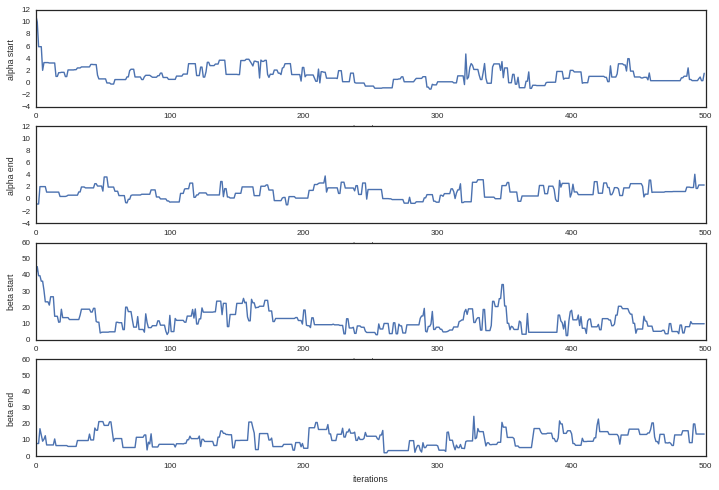

In [12]:
plt.figure(figsize=[12,8])

burnin = 500    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

# trace plot for alpha during burnin
plt.subplot(4,1,1) 
plt.plot(trace[:burnin,0])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha start")

# trace plot for alpha at the end 
# where we hopefully converged
plt.subplot(4,1,2) 
plt.plot(alpha[-burnin:])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha end")

# trace plot for beta during burnin
plt.subplot(4,1,3) 
plt.plot(trace[:burnin,1])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta start")

# trace plot for beta at the end 
# where we hopefully converged
plt.subplot(4,1,4) 
plt.plot(beta[-burnin:])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta end")


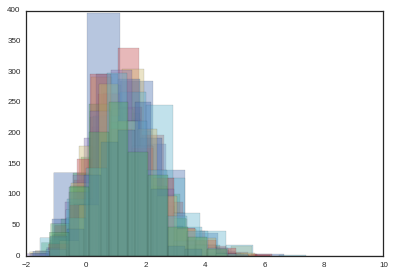

In [13]:
burnin = 1    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

subsetSize = 1000
for i in range(20):
    plt.hist(alpha[subsetSize*i:subsetSize*(i+1)], alpha=0.4)
    #plt.hist(alpha[subsetSize*i:subsetSize*(i+1)], histtype="step")

Let's try to have multiple chains

Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500


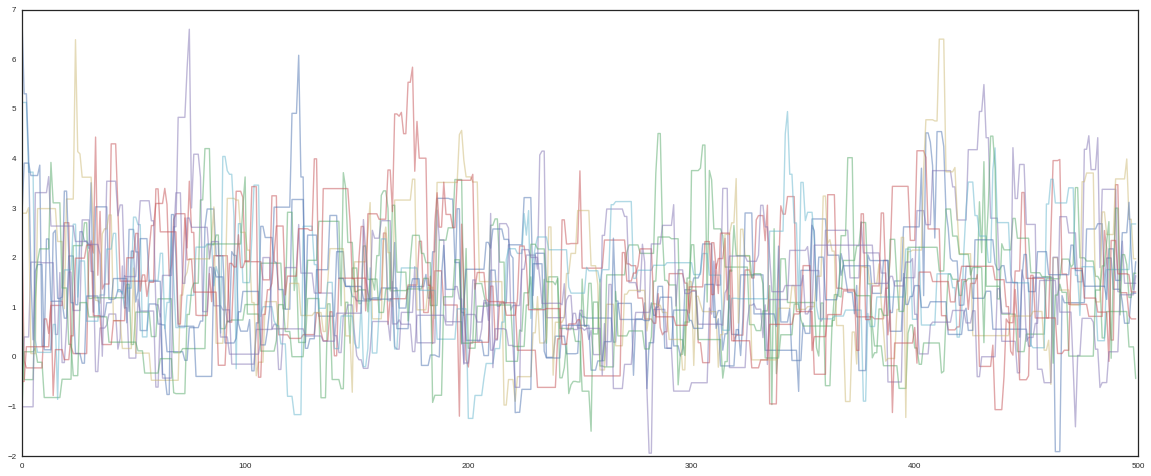

In [14]:
plt.figure(figsize=[20,8])

n_iter = 500
for i in range(10):
    start_alpha = np.random.rand(1)*10 - 3
    start_beta = np.random.rand(1)*40 - 10
    trace, acc = metropolis(n_iter, (start_alpha, start_beta), [3.0,12.0])
    plt.plot(trace[-500:,0], alpha=0.5)

Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500


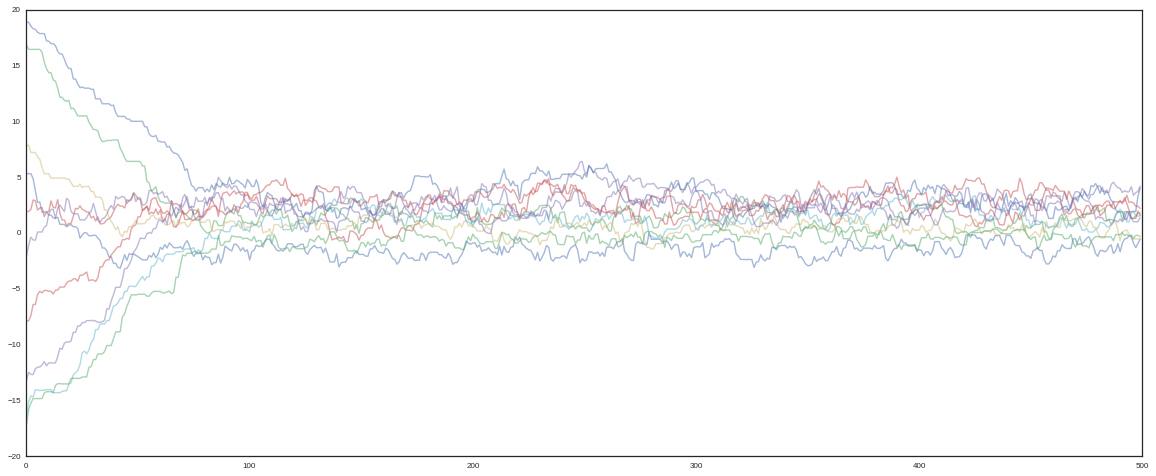

In [15]:
plt.figure(figsize=[20,8])

n_iter = 500
for i in range(10):
    start_alpha = np.random.rand(1)*40 - 20
    start_beta = np.random.rand(1)*40 - 10
    trace, acc = metropolis(n_iter, (start_alpha, start_beta), [0.5,0.05]) #10.0,50.0
    plt.plot(trace[-500:,0], alpha=0.5)

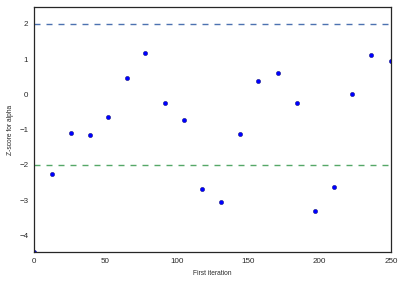

In [16]:
geweke_scores = pm.geweke(trace[:,0], first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "alpha")

# Now with PYMC

Pymc can make your life a lot simpler, but you need to get familiar with some syntax. 
Here is the same model as described above now in Pymc. 

In [17]:
#alpha = pm.Normal('alpha', mu=0.0, tau=0.01) 
#beta = pm.Normal('beta', mu=0.0, tau=0.01)

alpha = pm.Uniform("alpha", -3., 7.)
beta = pm.Uniform("beta", -10., 40.)

@pm.deterministic 
def theta(a=alpha, b=beta, x=X):
    return logitInv(a+b*x)

# deaths ~ binomial(n, p), 4 of them
deaths = pm.Binomial('deaths', n=[5,5,5,5], p=theta, value=Y, observed=True)

Now that we have our model specified in pymc we can do some sampling.

In [18]:
bioassay_model=pm.Model([alpha, beta, theta, deaths])
mcmc = pm.MCMC(bioassay_model)
mcmc.sample(iter=100000, burn=0)

 [-----------------100%-----------------] 100000 of 100000 complete in 7.0 sec

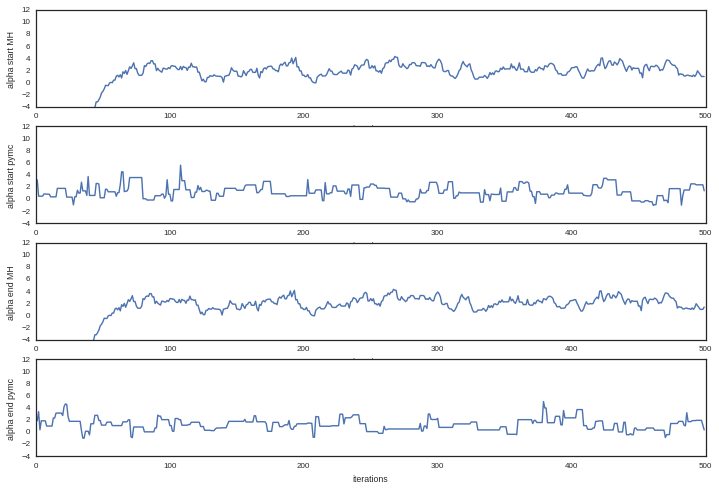

In [19]:
plt.figure(figsize=[12,8])

burnin = 500

# trace plot for alpha from our MH implementation
plt.subplot(4,1,1) 
plt.plot(trace[:burnin,0])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha start MH")

# trace plot for alpha from pymc
plt.subplot(4,1,2) 
plt.plot(alpha.trace()[:burnin])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha start pymc")

# trace plot for alpha from our MH implementation
plt.subplot(4,1,3) 
plt.plot(trace[-burnin:,0])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha end MH")

# trace plot for alpha from pymc
plt.subplot(4,1,4) 
plt.plot(alpha.trace()[-burnin:])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha end pymc")

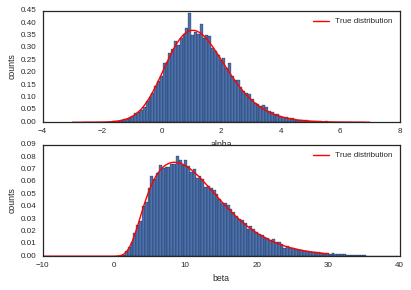

In [20]:
# histogram of alpha
plt.subplot(2,1,1) 
fig=plt.hist(alpha.trace(), bins=100, normed=True)
xx= np.linspace(-3,7,101)
pp_a = np.sum(pp, axis=1)
plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("alpha")
plt.ylabel("counts")

# histogram of beta
plt.subplot(2,1,2) 
fig=plt.hist(beta.trace(), bins=100, normed=True)
xx = np.linspace(-10, 30,100)
pp_b = np.sum(pp, axis=0)
plt.plot(xx, pp_b*1.5, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("beta")
plt.ylabel("counts")

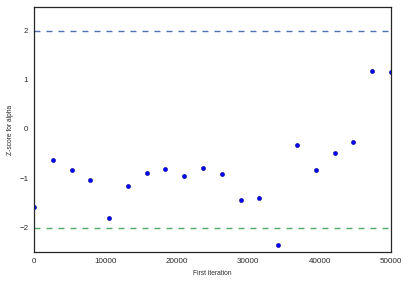

In [21]:
geweke_scores = pm.geweke(alpha.trace(), first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "alpha")

Plotting alpha


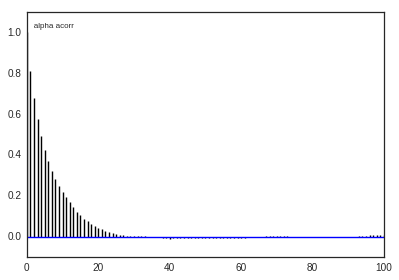

In [22]:
pm.Matplot.autocorrelation(alpha.trace(), "alpha")

We have quite some autocorrelation here. Why is this bad? It reduces our effective sample size!

In [23]:
bioassay_model=pm.Model([alpha, beta, theta, deaths])
mcmc = pm.MCMC(bioassay_model)
mcmc.sample(iter=220000, burn=20000, thin=2)

 [-----------------100%-----------------] 220000 of 220000 complete in 13.2 sec

In [24]:
len(alpha.trace())

100000

Plotting alpha


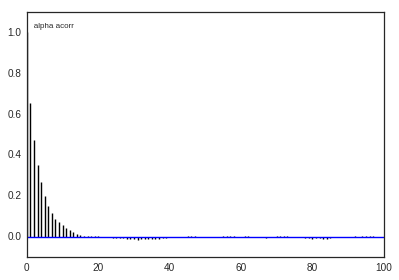

In [25]:
pm.Matplot.autocorrelation(alpha.trace(),"alpha")


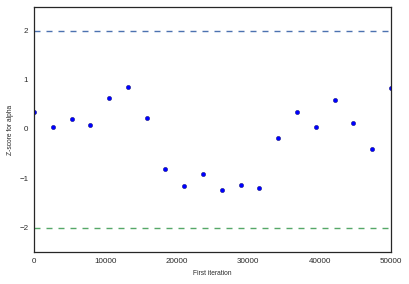

In [26]:
geweke_scores = pm.geweke(alpha.trace(), first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "alpha")

In [27]:
# Sampling multiple chains
mcmc.sample(iter=220000, burn=20000, thin=2)

 [-----------------100%-----------------] 220000 of 220000 complete in 13.1 sec

In [28]:
pm.gelman_rubin(mcmc)

{'alpha': 1.000065737681882,
 'beta': 1.0000812143303008,
 'theta': [1.0000071541383184,
  0.99999372092341443,
  1.0000249733891096,
  1.0000305545331591]}

In [29]:
pm.effective_n(mcmc)

{'alpha': 33074, 'beta': 31003, 'theta': [79699, 93479, 43082, 61783]}

# Some very convenient PYMC stuff

Plotting alpha


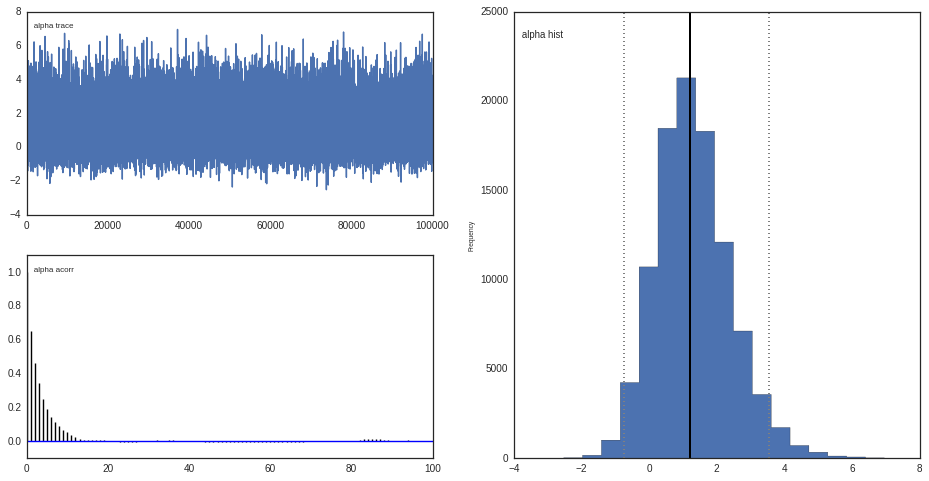

In [30]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(alpha, new=False)

In [31]:
mcmc.summary()


alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.317            1.101            0.006            [-0.703  3.579]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.593           0.553           1.229          1.985         3.738
	

theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.008            0.024            0.0              [ 0.     0.041]
	0.152            0.124            0.0              [ 0.     0.401]
	0.649            0.178            0.001            [ 0.315  0.964]
	0.992            0.028            0.0              [ 0.959  1.   ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|

In [32]:
mcmc.stats()

{'alpha': {'95% HPD interval': array([-0.70320338,  3.57941866]),
  'mc error': 0.0055226047305211023,
  'mean': 1.3166122156224431,
  'n': 200000,
  'quantiles': {2.5: -0.59319980905159497,
   25: 0.55276811806678339,
   50: 1.2291177722370867,
   75: 1.9852346439633091,
   97.5: 3.7377689033461188},
  'standard deviation': 1.1006328854531291},
 'beta': {'95% HPD interval': array([  2.52595946,  23.07305865]),
  'mc error': 0.030948282982360725,
  'mean': 11.629120913294715,
  'n': 200000,
  'quantiles': {2.5: 3.4362963354700882,
   25: 7.3726683611180768,
   50: 10.671163923132273,
   75: 14.833322264399211,
   97.5: 25.317592041761209},
  'standard deviation': 5.7279277746320778},
 'theta': {'95% HPD interval': array([[  6.85290362e-15,   5.13064364e-05,   3.14919259e-01,
            9.59211026e-01],
         [  4.08141816e-02,   4.01441194e-01,   9.64243021e-01,
            1.00000000e+00]]),
  'mc error': array([  8.59876975e-05,   4.42546800e-04,   7.62159719e-04,
           1.10